In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
import cv2 as cv
import torchlayers as tl
import os

In [2]:
trans = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor()])
trans_gray = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor(), transforms.Grayscale()])


datas = torchvision.datasets.ImageFolder(root = './data/kcar/lights', transform = trans)
train_size = int(len(datas) * 0.8)
test_size = len(datas) - train_size
train_sets, test_sets = torch.utils.data.random_split(datas, [train_size, test_size])

# edge_datas = torchvision.datasets.ImageFolder(root = './data/kcar_edge/lights', transform = trans_gray)
# edge_train_size = int(len(edge_datas) * 0.8)
# edge_test_size = len(edge_datas) - edge_train_size
# edge_train_sets, edge_test_sets = torch.utils.data.random_split(edge_datas, [edge_train_size, edge_test_size])

edge_train_sets = torchvision.datasets.ImageFolder(root = './data/kcar_edge/lights', transform = trans)
edge_test_sets = torchvision.datasets.ImageFolder(root = './data/kcar_edge/lights', transform = trans)
# train_sets = torchvision.datasets.ImageFolder(root = './data/kcar/lights', transform = trans)
# test_sets = torchvision.datasets.ImageFolder(root = './data/kcar/darks', transform = trans)
labels = edge_train_sets.classes
print(len(edge_train_sets))
print(len(edge_test_sets))
print(len(train_sets))
print(len(test_sets))
print(len(labels))
# print(test_sets)
# print(edge_test_sets)

# print(len(labels))
# for i in range(4):
#     img, label = train_sets[i]
#     print(labels[label])
#     plt.subplot(241 + i)
#     plt.imshow(np.clip(img.permute(1,2,0),0,1))
#     plt.tight_layout()
#     plt.show()
    # save_image(img, str(i)+'_.jpg')


24954
24954
19963
4991
51


In [10]:
# DataLoader 정의 - data 길이 달라지면 random_t_list 수정하기!
import random
random_train_list = list(range(1, len(train_sets)))
random.shuffle(random_train_list)
random_test_list = list(range(1, len(test_sets)))
random.shuffle(random_test_list)

train_loader = DataLoader(train_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
edge_train_loader = DataLoader(edge_train_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
test_loader = DataLoader(test_sets, batch_size = 32, sampler = random_test_list)
edge_test_loader = DataLoader(edge_test_sets, batch_size = 32, sampler = random_test_list)

print(len(train_loader))

624


In [73]:
model1 = torch.nn.Sequential(
    tl.Conv(64),  # specify ONLY out_channels
    tl.ReLU(),  # use torch.nn wherever you wish
    tl.BatchNorm(),  # BatchNormNd inferred from input
    tl.Conv(128),  # Default kernel_size equal to 3
    tl.ReLU(),
    tl.MaxPool(),
    tl.Conv(256, kernel_size=11),  # "same" padding as default
    # tl.ReLU(),
    tl.GlobalMaxPool(),
    tl.Linear(51),  # Output for 51 classes
)
model1 = tl.build(model1, torch.randn(1, 3, 120, 120))
model1.cuda()
model2 = torch.nn.Sequential(
    tl.Conv(64),  # specify ONLY out_channels
    torch.nn.ReLU(),  # use torch.nn wherever you wish
    tl.BatchNorm(),  # BatchNormNd inferred from input
    tl.Conv(128),  # Default kernel_size equal to 3
    tl.ReLU(),
    tl.MaxPool(),
    tl.Conv(256, kernel_size=11),  # "same" padding as default
    # tl.ReLU(),
    tl.GlobalMaxPool(),
    tl.Linear(51),  # Output for 51 classes
)
model2 = tl.build(model2, torch.randn(1, 3, 28, 28))
model2.cuda()

# one_way_edge_model = torch.nn.Sequential(
#     tl.Conv(64),  # specify ONLY out_channels
#     tl.ReLU(),  # use torch.nn wherever you wish
#     tl.BatchNorm(),  # BatchNormNd inferred from input
#     tl.Conv(128),  # Default kernel_size equal to 3
#     tl.ReLU(),
#     # tl.MaxPool(),
#     tl.Conv(256, kernel_size=11),  # "same" padding as default
#     # tl.ReLU(),
#     tl.GlobalMaxPool(),
#     tl.Linear(51),  # Output for 52 classes
# )
# one_way_edge_model = tl.build(one_way_edge_model, torch.randn(1,1,120,120))
# one_way_edge_model.cuda()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (7): GlobalMaxPool()
  (8): Linear(in_features=256, out_features=51, bias=True)
)

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
print(torch.cuda.is_available())
torch.cuda.empty_cache()

cuda:0 is available
True


In [4]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
 
        _, pred = output.topk(maxk, 1, True, True) #(52, 32)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)) # (5,32)
 
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [53]:
#one_way_edge_model 모델 학습
from torchvision.utils import make_grid
one_way_edge_model.train()
print(len(edge_train_loader))
for epoch in range(10):
    for index, (data, target) in enumerate(edge_train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = one_way_edge_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if index % 50 == 0:
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
            print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))
            
    scheduler.step()
    print("-----")

624
torch.Size([5, 32])
acc1 : 12.5, acc5 : 25.0
loss of 0 epoch, 0 index : 3.7275052070617676
torch.Size([5, 32])
acc1 : 9.375, acc5 : 18.75
loss of 0 epoch, 50 index : 3.8771634101867676
torch.Size([5, 32])
acc1 : 12.5, acc5 : 28.125
loss of 0 epoch, 100 index : 3.544606924057007
torch.Size([5, 32])
acc1 : 3.125, acc5 : 31.25
loss of 0 epoch, 150 index : 3.73066782951355
torch.Size([5, 32])
acc1 : 3.125, acc5 : 21.875
loss of 0 epoch, 200 index : 3.863187551498413
torch.Size([5, 32])
acc1 : 9.375, acc5 : 21.875
loss of 0 epoch, 250 index : 3.7861833572387695
torch.Size([5, 32])
acc1 : 3.125, acc5 : 21.875
loss of 0 epoch, 300 index : 3.9036777019500732
torch.Size([5, 32])
acc1 : 3.125, acc5 : 18.75
loss of 0 epoch, 350 index : 3.928554058074951
torch.Size([5, 32])
acc1 : 3.125, acc5 : 21.875
loss of 0 epoch, 400 index : 4.013636589050293
torch.Size([5, 32])
acc1 : 3.125, acc5 : 25.0
loss of 0 epoch, 450 index : 3.8772101402282715
torch.Size([5, 32])
acc1 : 9.375, acc5 : 31.25
loss of

KeyboardInterrupt: 

In [65]:
# one_way_edge_model 테스트
one_way_edge_model.eval()
correct = 0
total = 0
class_correct = np.zeros(51)
class_total = np.zeros(51)
count = 0
print(len(edge_test_loader))
print(len(labels))
with torch.no_grad():
    for (images, targets) in edge_test_loader:
        images = images.cuda()
        targets = targets.cuda()
        outputs = one_way_edge_model(images)
        _, predicted = torch.max(outputs.data, 1)
        acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
        print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        c = (predicted == targets).squeeze()
        count += 1
        for i in range(32):
            target = targets[i]
            class_correct[target] += c[i].item()
            class_total[target] += 1
        if count > len(edge_test_loader)/10:
            break
            
for i in range(51):
    print('Accuract of %5s : %2d %%' %(
        labels[i], 100 * class_correct[i] / class_total[i]))
        
print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

266
51
acc1 : 3.125, acc5 : 12.5
acc1 : 3.125, acc5 : 9.375
acc1 : 6.25, acc5 : 21.875
acc1 : 0.0, acc5 : 9.375
acc1 : 12.5, acc5 : 18.75
acc1 : 3.125, acc5 : 18.75
acc1 : 3.125, acc5 : 12.5
acc1 : 6.25, acc5 : 12.5
acc1 : 6.25, acc5 : 15.625
acc1 : 3.125, acc5 : 18.75
acc1 : 9.375, acc5 : 12.5
acc1 : 6.25, acc5 : 18.75
acc1 : 6.25, acc5 : 15.625
acc1 : 9.375, acc5 : 21.875
acc1 : 3.125, acc5 : 9.375
acc1 : 3.125, acc5 : 12.5
acc1 : 3.125, acc5 : 18.75
acc1 : 3.125, acc5 : 15.625
acc1 : 3.125, acc5 : 15.625
acc1 : 0.0, acc5 : 9.375
acc1 : 0.0, acc5 : 21.875
acc1 : 9.375, acc5 : 28.125
acc1 : 3.125, acc5 : 21.875
acc1 : 3.125, acc5 : 31.25
acc1 : 0.0, acc5 : 3.125
acc1 : 0.0, acc5 : 3.125
acc1 : 3.125, acc5 : 9.375
Accuract of G4 렉스턴 :  0 %
Accuract of    K3 :  0 %
Accuract of    K5 :  3 %
Accuract of    K7 :  0 %
Accuract of    K9 :  0 %
Accuract of   QM3 :  0 %
Accuract of   QM6 :  0 %
Accuract of   SM3 : 45 %
Accuract of   SM5 :  0 %
Accuract of SM520 :  0 %
Accuract of   SM6 :  0 %


In [9]:
one_way_model = torch.nn.Sequential(
    tl.Conv(64),  # specify ONLY out_channels
    tl.ReLU(),  # use torch.nn wherever you wish
    tl.BatchNorm(),  # BatchNormNd inferred from input
    tl.Conv(128),  # Default kernel_size equal to 3
    tl.ReLU(),
    tl.Conv(256, kernel_size=11),  # "same" padding as default
    tl.GlobalMaxPool(),  # Known from Keras
    tl.Linear(51),  # Output for 2 classes
)
one_way_model = tl.build(one_way_model, torch.randn(1, 3, 120, 120))
one_way_model.cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(128, 256, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (6): GlobalMaxPool()
  (7): Linear(in_features=256, out_features=51, bias=True)
)

In [10]:
#one_way_model 모델 학습
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(one_way_model.parameters(), lr=0.01, betas=(0.9, 0.99), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4,6,8], gamma=0.1)

one_way_model.train()
print(len(train_loader))
for epoch in range(10):
    for index, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = one_way_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if index % 50 == 0:
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
            print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))
            
    scheduler.step()
    print("-----")

780
acc1 : 3.125, acc5 : 12.5
loss of 0 epoch, 0 index : 4.012314319610596
acc1 : 0.0, acc5 : 3.125
loss of 0 epoch, 50 index : 4.001899719238281
acc1 : 12.5, acc5 : 31.25
loss of 0 epoch, 100 index : 3.584003448486328


KeyboardInterrupt: 

In [39]:
resnet101 = torchvision.models.resnet101(pretrained=True)
last_module = nn.Linear(1000, 51, bias=True)
resnet101.add_module('last_module', last_module)
resnet101.cuda()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\aristun/.cache\torch\hub\checkpoints\resnet101-5d3b4d8f.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# vgg_model = torchvision.models.vgg16(pretrained=True)
# last_module = nn.Linear(1000, 51, bias=True)
# vgg_model.add_module('last_module', last_module)
# vgg_model.cuda()
sqnet = torchvision.models.squeezenet1_1(pretrained=True)
last_module = nn.Linear(1000, 51, bias=True)
sqnet.add_module('last_module', last_module)
sqnet.cuda()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [28]:
#squeezenet1_1 모델 학습
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(sqnet.parameters(), lr=0.01, betas=(0.9, 0.99), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4,6,8], gamma=0.1)

sqnet.train()
print(len(train_loader))
for epoch in range(10):
    for index, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = sqnet(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if index % 50 == 0:
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
            print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))
            
    scheduler.step()
    print("-----")

624
acc1 : 0.0, acc5 : 0.0
loss of 0 epoch, 0 index : 17.49534034729004
acc1 : 6.25, acc5 : 25.0
loss of 0 epoch, 50 index : 4.2598114013671875
acc1 : 9.375, acc5 : 28.125
loss of 0 epoch, 100 index : 4.5622639656066895
acc1 : 12.5, acc5 : 40.625
loss of 0 epoch, 150 index : 4.300893306732178
acc1 : 3.125, acc5 : 28.125
loss of 0 epoch, 200 index : 4.167567253112793
acc1 : 0.0, acc5 : 12.5
loss of 0 epoch, 250 index : 4.45455265045166
acc1 : 0.0, acc5 : 15.625
loss of 0 epoch, 300 index : 4.496746063232422
acc1 : 9.375, acc5 : 21.875
loss of 0 epoch, 350 index : 3.874967336654663
acc1 : 3.125, acc5 : 15.625
loss of 0 epoch, 400 index : 4.554715633392334
acc1 : 3.125, acc5 : 15.625
loss of 0 epoch, 450 index : 4.418555736541748
acc1 : 6.25, acc5 : 31.25
loss of 0 epoch, 500 index : 3.80377459526062
acc1 : 12.5, acc5 : 34.375
loss of 0 epoch, 550 index : 4.277730464935303
acc1 : 0.0, acc5 : 21.875
loss of 0 epoch, 600 index : 4.316932201385498
-----
acc1 : 6.25, acc5 : 15.625
loss of 1 e

KeyboardInterrupt: 

In [12]:
# sq_net original image 학습
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 1e-3
optimizer = optim.Adam(sqnet.parameters(), lr=learning_rate)
# hyper-parameters
num_epochs = 10
num_batches = 32

sqnet.train()
trn_loss_list = []
val_loss_list = []
for epoch in range(4, num_epochs):
    trn_loss = 0.0
    for i, data in enumerate(train_loader):
        x, label = data

        x = x.cuda()
        label = label.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = sqnet(x)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        
        # 학습과정 출력
        if (i+1) % 300 == 1:
            sqnet.eval()
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, val in enumerate(test_loader):
                    val_x, val_label = val
                    val_x = val_x.cuda()
                    val_label =val_label.cuda()
                    val_output = sqnet(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    acc1, acc5 = accuracy(val_output, val_label, topk=(1, 5))
                    print("test data acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                
                       
            
            acc1, acc5 = accuracy(model_output, label, topk=(1, 5))
            print("train data acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(test_loader)))
                    
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(test_loader))
            trn_loss = 0.0
            sqnet.train()
        
        # del (memory issue)
        del loss
        del model_output

test data acc1 : 87.5, acc5 : 100.0
test data acc1 : 87.5, acc5 : 100.0
test data acc1 : 75.0, acc5 : 90.625
test data acc1 : 75.0, acc5 : 93.75
test data acc1 : 90.625, acc5 : 100.0
test data acc1 : 81.25, acc5 : 100.0
test data acc1 : 87.5, acc5 : 96.875
test data acc1 : 81.25, acc5 : 96.875
test data acc1 : 75.0, acc5 : 96.875
test data acc1 : 71.875, acc5 : 93.75
test data acc1 : 78.125, acc5 : 100.0
test data acc1 : 71.875, acc5 : 100.0
test data acc1 : 81.25, acc5 : 100.0
test data acc1 : 84.375, acc5 : 100.0
test data acc1 : 84.375, acc5 : 93.75
test data acc1 : 68.75, acc5 : 96.875
test data acc1 : 68.75, acc5 : 100.0
test data acc1 : 84.375, acc5 : 90.625
test data acc1 : 78.125, acc5 : 93.75
test data acc1 : 56.25, acc5 : 93.75
test data acc1 : 75.0, acc5 : 100.0
test data acc1 : 81.25, acc5 : 96.875
test data acc1 : 81.25, acc5 : 100.0
test data acc1 : 75.0, acc5 : 96.875
test data acc1 : 81.25, acc5 : 100.0
test data acc1 : 71.875, acc5 : 93.75
test data acc1 : 87.5, acc5 :

KeyboardInterrupt: 

In [70]:
# sqnet 테스트
correct = 0
total = 0
class_correct = list(0. for i in range(51))
class_total = list(0. for i in range(51))
sqnet.eval()
count = 0
print(len(edge_test_loader))
print(len(labels))
with torch.no_grad():
    for (images, targets) in edge_test_loader:
        images = images.cuda()
        targets = targets.cuda()
        outputs = sqnet(images)
        _, predicted = torch.max(outputs.data, 1)
        acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
        print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        c = (predicted == targets).squeeze()
        count += 1
        for i in range(32):
            target = targets[i]
            class_correct[target] += c[i].item()
            class_total[target] += 1
        if count > len(edge_test_loader):
            break
            
for i in range(51):
    print('Accuract of %5s : %2d %%' %(
        labels[i], 100 * class_correct[i] / class_total[i]))
        
print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

266
51
acc1 : 6.25, acc5 : 18.75
acc1 : 9.375, acc5 : 28.125
acc1 : 3.125, acc5 : 9.375
acc1 : 9.375, acc5 : 28.125
acc1 : 6.25, acc5 : 18.75
acc1 : 0.0, acc5 : 6.25
acc1 : 6.25, acc5 : 15.625
acc1 : 3.125, acc5 : 28.125
acc1 : 12.5, acc5 : 21.875
acc1 : 3.125, acc5 : 15.625
acc1 : 9.375, acc5 : 18.75
acc1 : 3.125, acc5 : 15.625
acc1 : 6.25, acc5 : 18.75
acc1 : 0.0, acc5 : 9.375
acc1 : 6.25, acc5 : 15.625
acc1 : 3.125, acc5 : 9.375
acc1 : 12.5, acc5 : 18.75
acc1 : 0.0, acc5 : 9.375
acc1 : 9.375, acc5 : 34.375
acc1 : 6.25, acc5 : 12.5
acc1 : 0.0, acc5 : 9.375
acc1 : 6.25, acc5 : 21.875
acc1 : 6.25, acc5 : 12.5
acc1 : 6.25, acc5 : 12.5
acc1 : 0.0, acc5 : 9.375
acc1 : 3.125, acc5 : 21.875
acc1 : 3.125, acc5 : 12.5
acc1 : 3.125, acc5 : 15.625
acc1 : 6.25, acc5 : 18.75
acc1 : 0.0, acc5 : 28.125
acc1 : 3.125, acc5 : 25.0
acc1 : 0.0, acc5 : 28.125
acc1 : 3.125, acc5 : 6.25
acc1 : 9.375, acc5 : 25.0
acc1 : 6.25, acc5 : 21.875
acc1 : 12.5, acc5 : 34.375
acc1 : 3.125, acc5 : 15.625
acc1 : 3.125,

IndexError: index 12 is out of bounds for dimension 0 with size 12

In [25]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.fc1 = nn.Linear(1000, 51)
        self.fc2 = nn.Linear(1000, 51)
        self.fc3 = nn.Linear(102, 51)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x1 = self.fc1(x1)
        x2 = self.modelB(x2)
        x2 = self.fc2(x2)

        x = torch.cat((x1, x2), dim=1)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):  
        size = x.size()[1:] 
        num_features = 1 
        for s in size: 
            num_features *= s 
        return num_features

resnet101 = torchvision.models.resnet101(pretrained=True)
resnet101.cuda()

# sqnet = torchvision.models.sqnet(pretrained=True)
sqnet = torch.load('sqnet_org(1)31(2)75.pt')
sqnet.cuda()

model = MyEnsemble(sqnet, resnet101)
model.cuda()
#모델 저장
# torch.save(model, 'ensemble(1)90(2)100.pt')
# model = torch.load('ensemble(1)90(2)100.pt')
# model.cuda()

MyEnsemble(
  (modelA): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expa

In [ ]:
#MyEnsemble 모델 학습 dark version
print(len(train_loader))
print(len(test_loader))
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# hyper-parameters
num_epochs = 10
num_batches = 32

model.train()
trn_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    for i, (data, edge_data) in enumerate(zip(train_loader, edge_train_loader)):
        x, label = data
        x2, label2 = edge_data

        x = x.cuda()
        label = label.cuda()
        x2 = x2.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = model(x, x2)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        
        # 학습과정 출력
        if (i+1) % 100 == 1: # every 100 mini-batches
            model.eval()
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, (val, edge_val) in enumerate(zip(test_loader, edge_test_loader)):
                    val_x, val_label = val
                    val_x2, val_label2 = edge_val
                    val_x = val_x.cuda()
                    val_x2 = val_x2.cuda()
                    val_label =val_label.cuda()
                    val_output = model(val_x, val_x2)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    if j > 50 * epoch:
                        print("testing data: "+ str(j * len(test_loader)))
                        break
                       
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(test_loader)
            ))
            acc1, acc5 = accuracy(model_output, label, topk=(1, 5))
            print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                    
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(test_loader))
            trn_loss = 0.0
            model.train()
        
        # del (memory issue)
        del loss
        del model_output

In [16]:
torch.save(model, 'ensemble_dark_only_90%.pt')

In [14]:
#MyEnsemble 모델 학습 dark version
print(len(train_loader))
print(len(test_loader))
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# hyper-parameters
num_epochs = 10
num_batches = 32

model.train()
trn_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    for i, (data, edge_data) in enumerate(zip(train_loader, edge_train_loader)):
        x, label = data
        x2, label2 = edge_data

        x = x.cuda()
        label = label.cuda()
        x2 = x2.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = model(x, x2)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        
        # 학습과정 출력
        if (i+1) % 100 == 1: # every 100 mini-batches
            model.eval()
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, (val, edge_val) in enumerate(zip(test_loader, edge_test_loader)):
                    val_x, val_label = val
                    val_x2, val_label2 = edge_val
                    val_x = val_x.cuda()
                    val_x2 = val_x2.cuda()
                    val_label =val_label.cuda()
                    val_output = model(val_x, val_x2)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    if j > 50 * epoch:
                        print("testing data: "+ str(j * len(test_loader)))
                        break
                       
            print("trn loss: {:.4f} | val loss: {:.4f}".format(
                trn_loss / 100, val_loss / len(test_loader)
            ))
            acc1, acc5 = accuracy(model_output, label, topk=(1, 5))
            print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                    
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(test_loader))
            trn_loss = 0.0
            model.train()
        
        # del (memory issue)
        del loss
        del model_output

213
54
testing data: 54
trn loss: 0.0007 | val loss: 0.0138
acc1 : 96.875, acc5 : 100.0
testing data: 54
trn loss: 0.1050 | val loss: 0.0197
acc1 : 100.0, acc5 : 100.0
testing data: 54
trn loss: 0.0958 | val loss: 0.0152
acc1 : 93.75, acc5 : 100.0
testing data: 2754
trn loss: 0.0003 | val loss: 0.4240
acc1 : 100.0, acc5 : 100.0


KeyboardInterrupt: 

In [14]:
#MyEnsemble 모델 학습
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10
num_batches = 32

trn_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    for i, (data, edge_data) in enumerate(zip(train_loader, edge_train_loader)):
        x, label = data
        x2, label2 = edge_data

        x = x.cuda()
        label = label.cuda()
        x2 = x2.cuda()
        optimizer.zero_grad()
        model_output = model(x, x2)
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
        trn_loss += loss.item()
        
        # 학습과정 출력
        if (i+1) % 300 == 0 and epoch > 4:
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, (val, edge_val) in enumerate(zip(test_loader, edge_test_loader)):
                    val_x, val_label = val
                    val_x2, val_label2 = edge_val
                    val_x = val_x.cuda()
                    val_x2 = val_x2.cuda()
                    val_label =val_label.cuda()
                    val_output = model(val_x, val_x2)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    if j > 50 * epoch:
                        print("testing : "+ str(j))
                        break
                       
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(test_loader)
            ))
            acc1, acc5 = accuracy(model_output, label, topk=(1, 5))
            print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                    
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(test_loader))
            trn_loss = 0.0
        
        # del (memory issue)
        del loss
        del model_output

780
266
testing : 1
epoch: 1/10 | step: 300/32 | trn loss: 3.3008 | val loss: 0.0819
acc1 : 59.375, acc5 : 96.875
testing : 1
epoch: 1/10 | step: 600/32 | trn loss: 3.2198 | val loss: 0.0419
acc1 : 65.625, acc5 : 100.0
testing : 51
epoch: 2/10 | step: 300/32 | trn loss: 2.5266 | val loss: 2.2743
acc1 : 78.125, acc5 : 96.875
testing : 51
epoch: 2/10 | step: 600/32 | trn loss: 2.4812 | val loss: 3.7148
acc1 : 59.375, acc5 : 100.0
testing : 101
epoch: 3/10 | step: 300/32 | trn loss: 2.1622 | val loss: 3.7705
acc1 : 71.875, acc5 : 100.0
testing : 101
epoch: 3/10 | step: 600/32 | trn loss: 2.0995 | val loss: 6.5182
acc1 : 68.75, acc5 : 100.0
testing : 151
epoch: 4/10 | step: 300/32 | trn loss: 1.8288 | val loss: 5.9742
acc1 : 75.0, acc5 : 100.0
testing : 151
epoch: 4/10 | step: 600/32 | trn loss: 1.7444 | val loss: 5.8404
acc1 : 90.625, acc5 : 100.0
testing : 201
epoch: 5/10 | step: 300/32 | trn loss: 1.6155 | val loss: 7.1542
acc1 : 81.25, acc5 : 100.0
testing : 201
epoch: 5/10 | step: 600

In [22]:
# MyEnsemble 테스트
model.eval()
correct = 0
total = 0
class_correct = np.zeros(51)
class_total = np.zeros(51)
count = 0
print(len(test_loader))
print(len(labels))
with torch.no_grad():
    for index, ((images, targets), (edge_images, edge_target)) in enumerate(zip(test_loader, edge_test_loader)):
        images = images.cuda()
        edge_images = edge_images.cuda()
        targets = targets.cuda()

        outputs = model(images, edge_images)
        _, predicted = torch.max(outputs.data, 1)
        acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
        print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        c = (predicted == targets).squeeze()
        count += 1
        for i in range(32):
            target = targets[i]
            class_correct[target] += c[i].item()
            class_total[target] += 1
        if count > len(test_loader)/10:
            break
            
for i in range(51):
    print('Accuract of %5s : %2d %%' %(
        labels[i], 100 * class_correct[i] / class_total[i]))
        
print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

156
51


RuntimeError: mat1 dim 1 must match mat2 dim 0

In [79]:
#MyEnsemble 모델 학습
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(sqnet.parameters(), lr=0.01, betas=(0.9, 0.99), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4,6,8], gamma=0.1)

model.train()
print(len(train_loader))
for epoch in range(10):
    for index, ((data, target), (edge_data, edge_target)) in enumerate(zip(train_loader, edge_train_loader)):
        data, target = data.cuda(), target.cuda()
        edge_data, edge_target = edge_data.cuda(), target.cuda()

        output = model(data, edge_data)
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if index % 50 == 0:
            acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
            print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
            print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))
    
    scheduler.step()
    print("-----")



780


RuntimeError: mat1 dim 1 must match mat2 dim 0

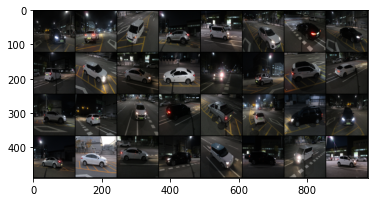

GroundTruth:   카니발 하이리무진        스토닉         레이     스포티지 R


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [24]:
def imshow(img):
    # img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labs = dataiter.next()
edge_dataiter = iter(edge_test_loader)
edge_images, labs = edge_dataiter.next()

# 이미지 출력하기
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%10s' % labels[labs[j]] for j in range(4)))

outputs = model(images, edge_images)
_, predicted = torch.max(outputs, 1)
print('Predicted : ', ' '.join('%10s' % labels[predicted[j]] for j in range(4)))

In [ ]:
PATH = './cnn_ensemble.pth'
torch.save(model.state_dict(), PATH)
# model = model()
# model.load_state_dict(torch.load(PATH))

In [28]:
print(classes[0])
print(len(classes))
print(len(labels))

tensor(8, device='cuda:0')
32
32


In [28]:
correct = 0
total = 0
with torch.no_grad():
    for ((images, labels), (edge_images, edge_target)) in zip(test_loader, edge_test_loader):
        images = images.cuda()
        edge_images = edge_images.cuda()
        labels = labels.cuda()
        outputs = model(images, edge_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


In [29]:
print(len(labels))

32


In [34]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
classes = labels
count = 0
with torch.no_grad():
    for ((images, labels), (edge_images, edge_target)) in zip(test_loader, edge_test_loader):
    # for data in test_loader:
        images = images.cuda()
        edge_images = edge_images.cuda()
        labels = labels.cuda()
        outputs = model(images, edge_images)
        _, prediceted = torch.max(outputs.data, 1)
        print(prediceted)
        print(labels)
        c = (predicted == labels).squeeze()
        count += 1
        for i in range(32):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        if count > 200:
            break
            
for i in range(51):
    print('Accuract of %5s : %2d %%' %(
        classes[i], 100 * class_correct[i] / class_total[i]))

tensor([ 3, 12,  2, 43, 14,  3,  5,  3, 14, 14, 32, 34,  3, 18, 46,  3,  3,  2,
         1,  7, 46, 18, 39,  3, 43, 37, 33,  3, 22,  3, 14,  1],
       device='cuda:0')
tensor([37, 22, 16, 26, 14, 25,  4, 31, 14, 47, 32, 17, 14, 18, 25, 23, 25, 12,
        27, 36, 41, 24, 35, 37, 43,  7,  3, 36, 30, 36, 14, 12],
       device='cuda:0')


RuntimeError: The size of tensor a (12) must match the size of tensor b (32) at non-singleton dimension 0

In [ ]:
model.eval()  # test
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    output = one_way_model(data)
    test_loss += one_way_criterion(output, target).item() # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    print("pred : "+str(pred)+"view as : "+str(target.view_as(pred)))
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))